In [6]:
# ======================
# Preprocesamiento de datos para el dataset 'startup-success-prediction'
# ======================

!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler

# ======================
# 1. Descarga y carga del dataset original
# ======================
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")
csv_path = os.path.join(path, "startup data.csv")
df = pd.read_csv(csv_path)

# ======================
# 2. Limpieza inicial de columnas irrelevantes
# ======================
initial_drop = [
    'Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'id', 'object_id', 'name'
]
df.drop(columns=[c for c in initial_drop if c in df.columns], inplace=True)

# ======================
# 3. Conversión de columnas de fecha
# ======================
for c in ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# ======================
# 4. Asegurar existencia de la columna 'status'
# ======================
if 'status' not in df.columns:
    raw = pd.read_csv(csv_path, usecols=['status'])
    df['status'] = raw['status']

# ======================
# 5. Creación de variables temporales derivadas
# ======================
fecha_corte = pd.to_datetime("2025-01-01")
df['lifetime_years'] = ((df['closed_at'].fillna(fecha_corte) - df['founded_at']).dt.days / 365).round(2)
df['funding_delay_years'] = ((df['first_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['last_milestone_delay_years'] = ((df['last_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['post_funding_duration_years'] = ((df['closed_at'].fillna(fecha_corte) - df['last_funding_at']).dt.days / 365).round(2)

# ======================
# 6. Eliminación de observaciones con errores temporales
# ======================
mask = (
    (df['lifetime_years'] < 0) |
    (df['funding_delay_years'] < 0) |
    (df['last_milestone_delay_years'] < 0) |
    (df['post_funding_duration_years'] < 0) |
    (df.get('age_first_funding_year', 0) < 0) |
    (df.get('age_last_funding_year', 0) < 0) |
    (df.get('age_first_milestone_year', 0) < 0) |
    (df.get('age_last_milestone_year', 0) < 0)
)
df = df.loc[~mask].copy()

# ======================
# 7. Clasificación sector y agrupación de ciudades
# ======================
tech = {'software', 'web', 'mobile', 'enterprise'}
df['main_sector'] = df['category_code'].apply(lambda x: 'tech' if x in tech else 'non_tech')

top = df['city'].value_counts()
freq = top[top > 20].index
df['city_grouped'] = df['city'].apply(lambda x: x if x in freq else 'other')

# ======================
# 8. Escalado de variables numéricas
# ======================
scaler = StandardScaler()
for col in ['funding_total_usd', 'relationships', 'avg_participants']:
    if col in df.columns:
        df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])

# ======================
# 9. Variables booleanas derivadas
# ======================
df['has_milestones'] = df['milestones'] > 0
df['has_late_funding'] = (df.get('has_roundC', 0) == 1) | (df.get('has_roundD', 0) == 1)

# ======================
# 10. Eliminación de columnas redundantes
# ======================
derived_drop = [
    'city', 'category_code', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
    'milestones', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'funding_total_usd', 'relationships', 'avg_participants'
]

extra_drop = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'state_code', 'zip_code', 'latitude', 'longitude',
    'has_milestone_info', 'status', 'is_top500'
]

drop_all = derived_drop + extra_drop + [c for c in df.columns if c.startswith('is_')]
df.drop(columns=[c for c in drop_all if c in df.columns], inplace=True)

# ======================
# 11. Separación de variable objetivo
# ======================
X = df.drop(columns='labels')
y = df['labels'].astype(int).values

# ======================
# 12. Resultado final
# ======================
print("Columnas finales disponibles para modelado:", X.columns.tolist())
print("Número de muestras:", X.shape[0])

Columnas finales disponibles para modelado: ['funding_rounds', 'has_VC', 'has_angel', 'lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years', 'main_sector', 'city_grouped', 'funding_total_usd_scaled', 'relationships_scaled', 'avg_participants_scaled', 'has_milestones', 'has_late_funding']
Número de muestras: 825


Accuracy en test: 0.9878787878787879

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9649    1.0000    0.9821        55
           1     1.0000    0.9818    0.9908       110

    accuracy                         0.9879       165
   macro avg     0.9825    0.9909    0.9865       165
weighted avg     0.9883    0.9879    0.9879       165



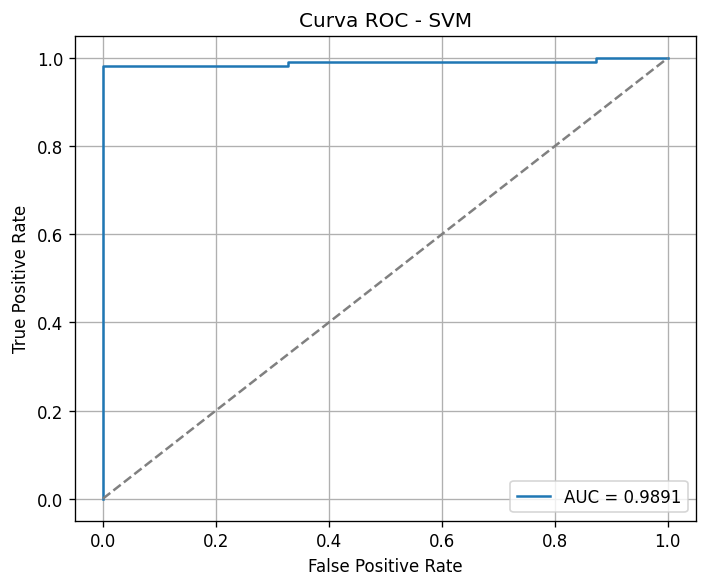

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# 1. División del dataset
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ======================
# 2. Preprocesamiento categórico
# ======================
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# ======================
# 3. Definición del pipeline
# ======================
pipe = Pipeline([
    ('prep', preprocessor),
    ('svc', SVC(kernel='rbf', C=1, gamma='scale', probability=True))
])

# ======================
# 4. Entrenamiento del modelo
# ======================
pipe.fit(X_train, y_train)

# ======================
# 5. Evaluación
# ======================
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("Accuracy en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, digits=4))

# ======================
# 6. Curva ROC y AUC
# ======================
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5), dpi=120)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 851.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66163 | val_accuracy: 0.69697 |  0:00:00s
epoch 1  | loss: 0.32231 | val_accuracy: 0.69091 |  0:00:00s
epoch 2  | loss: 0.19854 | val_accuracy: 0.69697 |  0:00:01s
epoch 3  | loss: 0.09911 | val_accuracy: 0.69697 |  0:00:01s
epoch 4  | loss: 0.0554  | val_accuracy: 0.72727 |  0:00:01s
epoch 5  | loss: 0.05128 | val_accuracy: 0.76364 |  0:00:01s
epoch 6  | loss: 0.04597 | val_accuracy: 0.78182 |  0:00:01s
epoch 7  | loss: 0.0434  | val_accuracy: 0.83636 |  0:00:01s
epoch 8  | loss: 0.06092 | val_accuracy: 0.84242 |  0:00:01s
epoch 9  | loss: 0.03506 | val_accuracy: 0.86667 |  0:00:02s
epoch 10 | loss: 0.05406 | val_accuracy: 0.90303 |  0:00:02s
epoch 11 | loss: 0.03183 | val_accuracy: 0.89697 |  0:00:02s
epoch 12 | loss: 0.03949 | val_accuracy: 0.91515 |  0:00:02s
epoch 13 | loss: 0.03506 | val_accuracy: 0.91515 |  0:00:02s
epoch 14 | loss: 0.04231 | val_accuracy: 0.92121 |  0:00:02s
epoch 15 | loss: 0.02897 | val_accuracy: 0.92121 |  0:00:02s
epoch 16 | loss: 0.03994

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


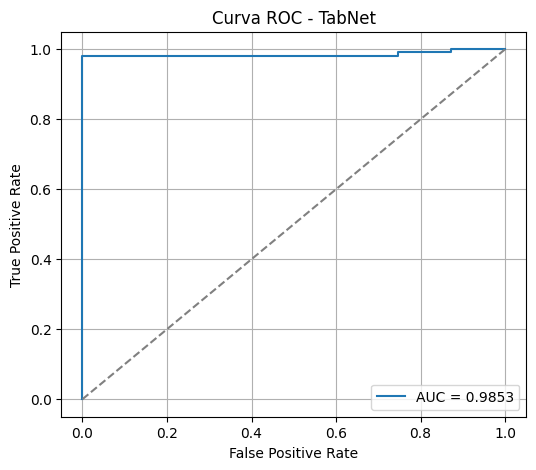

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Copia del dataframe para no modificar el original
df_tabnet = df.copy()

# Codificación de variables categóricas
cat_cols = df_tabnet.select_dtypes(include=['object', 'bool', 'category']).columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_tabnet[col] = le.fit_transform(df_tabnet[col])
    encoders[col] = le

# Separación de variables predictoras y objetivo
X_tabnet = df_tabnet.drop(columns='labels').values
y_tabnet = df_tabnet['labels'].values

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X_tabnet, y_tabnet, test_size=0.2, stratify=y_tabnet, random_state=42)

# Entrenamiento del modelo TabNet
tabnet_model = TabNetClassifier(seed=42)
tabnet_model.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=128,
    virtual_batch_size=64
)

# Evaluación
y_pred = tabnet_model.predict(X_test)
y_proba = tabnet_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print("AUC:", roc_auc_score(y_test, y_proba))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - TabNet")
plt.legend()
plt.grid()
plt.show()